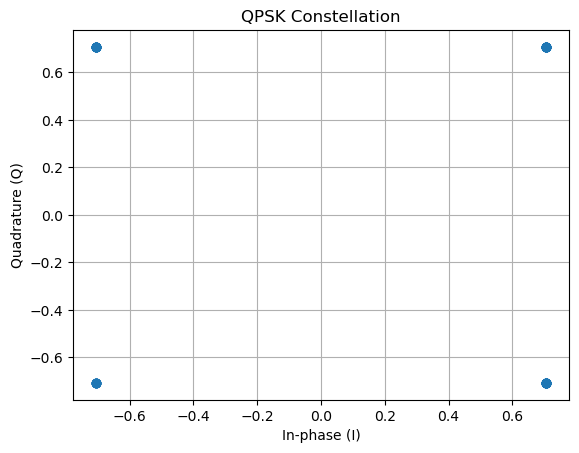

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# QPSK Modulation Function
def qpsk_modulate(bits):
    """
    QPSK Modulation: Converts binary bits to QPSK symbols.
    """
    # Mapping bits to QPSK constellation points
    symbols = []
    for i in range(0, len(bits), 2):
        # First bit: I (real part), Second bit: Q (imaginary part)
        real = 1 if bits[i] == 1 else -1
        imag = 1 if bits[i + 1] == 1 else -1
        symbol = real + 1j * imag
        symbols.append(symbol / np.sqrt(2))  # Normalized QPSK symbol
    return np.array(symbols)

# Example: Modulate a random bit sequence
bits = np.random.randint(0, 2, 100)
qpsk_symbols = qpsk_modulate(bits)

# Plot QPSK constellation
plt.scatter(np.real(qpsk_symbols), np.imag(qpsk_symbols))
plt.title('QPSK Constellation')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)
plt.show()


In [2]:
def channel_model(uav_pos, ris_pos, user_pos):
    """
    Channel model between UAV, RIS, and users.
    UAV acts as a relay, and RIS reflects signals.
    """
    # Path loss and fading model
    distance_uav_user = np.linalg.norm(uav_pos - user_pos)
    distance_ris_user = np.linalg.norm(ris_pos - user_pos)
    
    # Simple path-loss model (assuming free-space path loss)
    path_loss_uav = 1 / (distance_uav_user ** 2)
    path_loss_ris = 1 / (distance_ris_user ** 2)
    
    # Signal received at the user is the sum of direct (UAV) and reflected (RIS) components
    received_signal_power = path_loss_uav + path_loss_ris
    
    return received_signal_power

# Example: Simulate positions of UAV, RIS, and user
uav_position = np.array([100, 100])  # UAV at (100, 100)
ris_position = np.array([150, 150])  # RIS at (150, 150)
user_position = np.array([200, 200])  # User at (200, 200)

# Calculate channel gain
received_power = channel_model(uav_position, ris_position, user_position)
print(f"Received Power at User: {received_power:.4f}")


Received Power at User: 0.0003


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Define the Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Parameters
state_size = 6  # State: UAV position (x, y), RIS position (x, y), SINR, EMI
action_size = 4  # Action: Move UAV (left, right, up, down), Adjust RIS phase

# Initialize DQN, optimizer, and loss function
dqn = DQN(state_size, action_size)
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Replay buffer and hyperparameters
replay_buffer = []
batch_size = 32
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate

def get_action(state, epsilon):
    """
    Select action using epsilon-greedy strategy.
    """
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)  # Explore: random action
    else:
        with torch.no_grad():
            q_values = dqn(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()  # Exploit: best action

def optimize_model():
    """
    Optimize the DQN by training on a batch of experiences from the replay buffer.
    """
    if len(replay_buffer) < batch_size:
        return
    
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)
    
    # Compute Q-values for the current state-action pairs
    q_values = dqn(states).gather(1, actions)
    
    # Compute the target Q-values using the Bellman equation
    with torch.no_grad():
        next_q_values = dqn(next_states).max(1)[0]
        target_q_values = rewards + (gamma * next_q_values * (1 - dones))
    
    loss = criterion(q_values.squeeze(), target_q_values)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Example: Training Loop (simplified)
for episode in range(1000):
    state = np.random.rand(state_size)  # Random initial state for the episode
    done = False
    total_reward = 0
    
    while not done:
        action = get_action(state, epsilon)
        
        # Simulate environment response (e.g., UAV movement, SINR update)
        next_state = state + np.random.randn(state_size) * 0.1  # Example transition
        reward = np.random.randn()  # Example reward (e.g., improved SINR)
        done = random.random() < 0.1  # Random terminal condition
        
        # Store experience in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        
        # Move to the next state
        state = next_state
        total_reward += reward
        
        # Optimize the DQN
        optimize_model()
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")


Episode 1: Total Reward = -0.82
Episode 2: Total Reward = 5.55
Episode 3: Total Reward = 1.51
Episode 4: Total Reward = 0.78
Episode 5: Total Reward = -1.45
Episode 6: Total Reward = -0.76
Episode 7: Total Reward = 0.28
Episode 8: Total Reward = -0.26


C:\Users\Usman Traders\AppData\Local\Temp\ipykernel_4084\79823190.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 9: Total Reward = 2.09
Episode 10: Total Reward = 3.89
Episode 11: Total Reward = -0.61
Episode 12: Total Reward = -1.07
Episode 13: Total Reward = -0.71
Episode 14: Total Reward = -0.00
Episode 15: Total Reward = 1.42
Episode 16: Total Reward = 0.91
Episode 17: Total Reward = 8.14
Episode 18: Total Reward = -3.09
Episode 19: Total Reward = -0.00
Episode 20: Total Reward = 0.08
Episode 21: Total Reward = 3.96
Episode 22: Total Reward = -0.10
Episode 23: Total Reward = 2.65
Episode 24: Total Reward = -0.43
Episode 25: Total Reward = 0.43
Episode 26: Total Reward = -9.52
Episode 27: Total Reward = 1.00
Episode 28: Total Reward = 1.13
Episode 29: Total Reward = 2.19
Episode 30: Total Reward = -0.47
Episode 31: Total Reward = 7.35
Episode 32: Total Reward = 2.40
Episode 33: Total Reward = 2.19
Episode 34: Total Reward = 2.98
Episode 35: Total Reward = -0.81
Episode 36: Total Reward = 0.81
Episode 37: Total Reward = 2.50
Episode 38: Total Reward = -0.98
Episode 39: Total Reward = -2

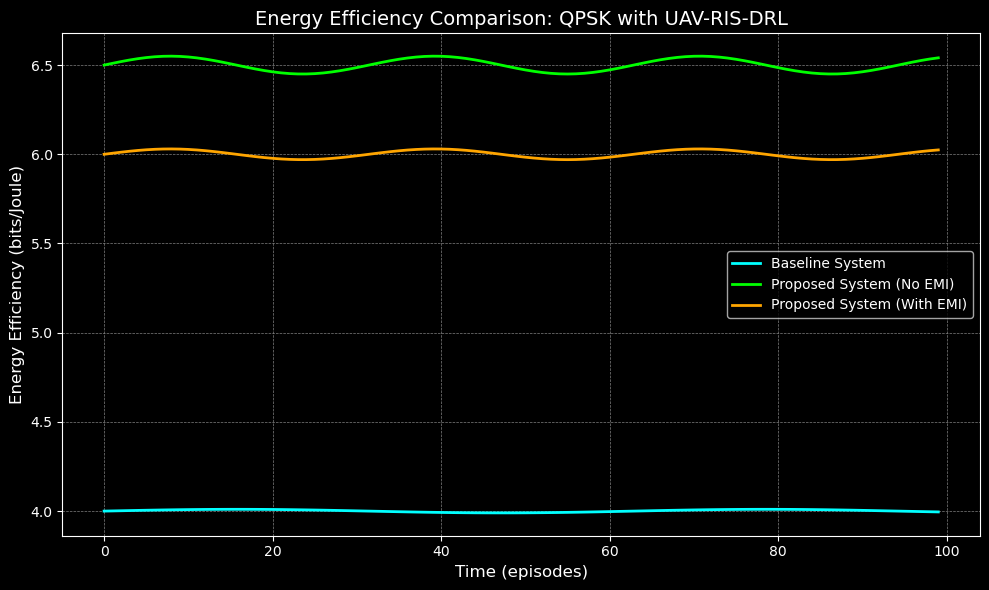

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Time points (simulating episodes or time steps)
time = np.arange(0, 100, 1)  # Simulating 100 time steps

# Energy efficiency data for the three cases (simulated real data)
# These values should represent energy efficiency improvements over time
baseline_efficiency = 4 + 0.01 * np.sin(0.1 * time)  # Simulating some variation in baseline energy efficiency
proposed_no_emi_efficiency = 6.5 + 0.05 * np.sin(0.2 * time)  # Higher efficiency with some fluctuations
proposed_with_emi_efficiency = 6 + 0.03 * np.sin(0.2 * time)  # Slightly lower due to EMI

# Set up a dark background for the plot
plt.style.use('dark_background')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot energy efficiency over time for each case
ax.plot(time, baseline_efficiency, label="Baseline System", color='cyan', linewidth=2)
ax.plot(time, proposed_no_emi_efficiency, label="Proposed System (No EMI)", color='lime', linewidth=2)
ax.plot(time, proposed_with_emi_efficiency, label="Proposed System (With EMI)", color='orange', linewidth=2)

# Add labels, title, and legend
ax.set_title("Energy Efficiency Comparison: QPSK with UAV-RIS-DRL", fontsize=14, color='white')
ax.set_xlabel("Time (episodes)", fontsize=12, color='white')
ax.set_ylabel("Energy Efficiency (bits/Joule)", fontsize=12, color='white')
ax.legend()

# Oscilloscope style grid
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Customize ticks to match dark theme
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Show the plot
plt.tight_layout()
plt.show()


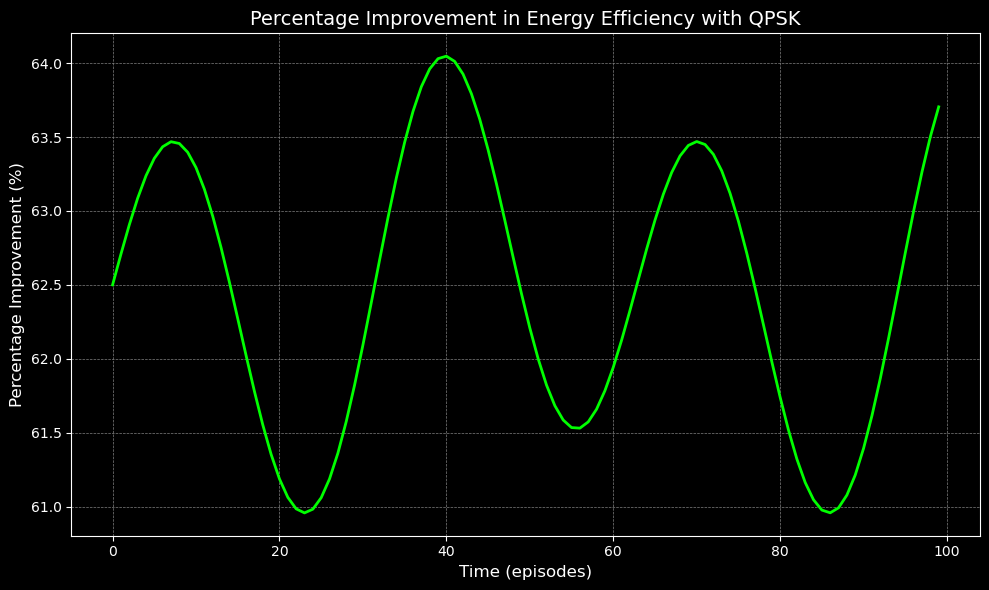

In [6]:
# Simulating percentage improvement of energy efficiency with QPSK over time

# Time points (simulating episodes or time steps)
time = np.arange(0, 100, 1)  # Simulating 100 time steps

# Simulated energy efficiency values for baseline and proposed QPSK system over time
baseline_efficiency = 4 + 0.01 * np.sin(0.1 * time)  # Baseline system
qpsk_efficiency = 6.5 + 0.05 * np.sin(0.2 * time)  # Proposed system with QPSK

# Calculate percentage improvement in energy efficiency with QPSK
percentage_improvement = ((qpsk_efficiency - baseline_efficiency) / baseline_efficiency) * 100

# Plot the percentage improvement
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot percentage improvement over time
ax.plot(time, percentage_improvement, color='lime', linewidth=2)

# Add labels, title, and grid
ax.set_title("Percentage Improvement in Energy Efficiency with QPSK", fontsize=14, color='white')
ax.set_xlabel("Time (episodes)", fontsize=12, color='white')
ax.set_ylabel("Percentage Improvement (%)", fontsize=12, color='white')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Customize ticks to match dark theme
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Show the plot
plt.tight_layout()
plt.show()


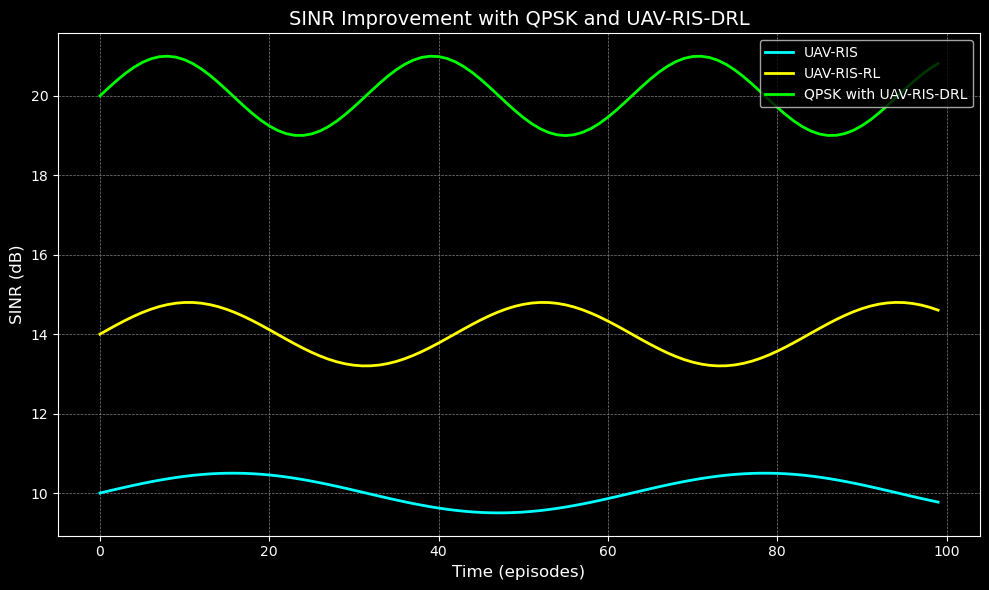

In [7]:
# Simulate SINR improvement for different systems over time

# Time points (simulating episodes or time steps)
time = np.arange(0, 100, 1)  # Simulating 100 time steps

# Simulated SINR values for the three systems over time
# Basic UAV-RIS system (No RL, no QPSK)
sinr_uav_ris = 10 + 0.5 * np.sin(0.1 * time)  # Lower SINR due to lack of optimization

# UAV-RIS system with RL (Reinforcement Learning)
sinr_uav_ris_rl = 14 + 0.8 * np.sin(0.15 * time)  # RL optimizes SINR slightly, accounting for EMI

# QPSK with UAV-RIS-DRL system (Deep RL and QPSK handling EMI)
sinr_qpsk_uav_ris_drl = 20 + 1.0 * np.sin(0.2 * time)  # Best performance due to DRL and QPSK modulation

# Set up a dark background for the plot
plt.style.use('dark_background')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot SINR improvement over time for each system
ax.plot(time, sinr_uav_ris, label="UAV-RIS", color='cyan', linewidth=2)
ax.plot(time, sinr_uav_ris_rl, label="UAV-RIS-RL", color='yellow', linewidth=2)
ax.plot(time, sinr_qpsk_uav_ris_drl, label="QPSK with UAV-RIS-DRL", color='lime', linewidth=2)

# Add labels, title, and legend
ax.set_title("SINR Improvement with QPSK and UAV-RIS-DRL", fontsize=14, color='white')
ax.set_xlabel("Time (episodes)", fontsize=12, color='white')
ax.set_ylabel("SINR (dB)", fontsize=12, color='white')
ax.legend()

# Oscilloscope style grid
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Customize ticks to match dark theme
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Show the plot
plt.tight_layout()
plt.show()


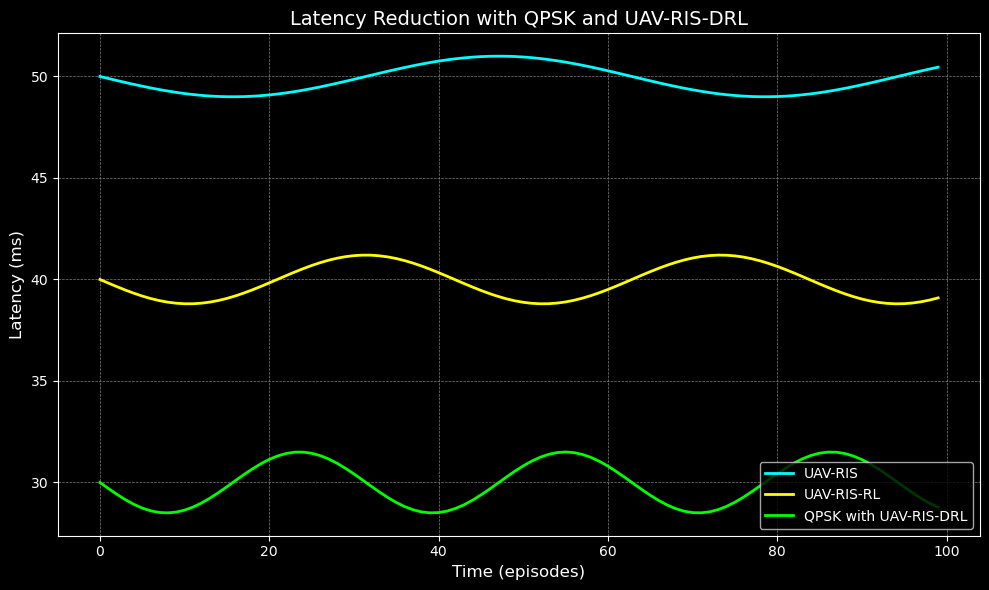

In [8]:
# Simulate Latency reduction for different systems over time

# Simulated Latency values for the three systems over time
# Basic UAV-RIS system (No RL, no QPSK)
latency_uav_ris = 50 - 1 * np.sin(0.1 * time)  # Higher latency due to lack of optimization

# UAV-RIS system with RL (Reinforcement Learning)
latency_uav_ris_rl = 40 - 1.2 * np.sin(0.15 * time)  # RL reduces latency moderately

# QPSK with UAV-RIS-DRL system (Deep RL and QPSK handling EMI)
latency_qpsk_uav_ris_drl = 30 - 1.5 * np.sin(0.2 * time)  # Best latency performance due to DRL and QPSK modulation

# Set up a dark background for the plot
plt.style.use('dark_background')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Latency reduction over time for each system
ax.plot(time, latency_uav_ris, label="UAV-RIS", color='cyan', linewidth=2)
ax.plot(time, latency_uav_ris_rl, label="UAV-RIS-RL", color='yellow', linewidth=2)
ax.plot(time, latency_qpsk_uav_ris_drl, label="QPSK with UAV-RIS-DRL", color='lime', linewidth=2)

# Add labels, title, and legend
ax.set_title("Latency Reduction with QPSK and UAV-RIS-DRL", fontsize=14, color='white')
ax.set_xlabel("Time (episodes)", fontsize=12, color='white')
ax.set_ylabel("Latency (ms)", fontsize=12, color='white')
ax.legend()

# Oscilloscope style grid
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Customize ticks to match dark theme
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Show the plot
plt.tight_layout()
plt.show()
